### Example G
Herein, we demonstrate how to use a battery unit hybridized with geothermal with diaurnal dispatch schedule.

In [1]:
# Only needed when FGEM is NOT installed by user
import sys
sys.path.insert(1, '../')

from fgem.world import World
from fgem.utils.config import get_config_from_json
from tqdm import tqdm

import numpy as np

In [2]:
def battery_step_update_record(project, m_prd=130, charge_time=(10, 14), discharge_time=(17, 21)):
    
    # UPDATE: we first update project state (also, we override parameters if needed)

    if (project.time_curr.hour >= charge_time[0]) and (project.time_curr.hour <= charge_time[1]):
        max_charge_power = (project.battery.energy_capacity - project.battery.energy_content)/project.timestep_hrs
        p_bat_ppin = np.clip(project.battery_power_capacity[0], 0, max_charge_power)
        p_bat_out = 0
        
    elif (project.time_curr.hour >= discharge_time[0]) and (project.time_curr.hour <= discharge_time[1]):
        max_discharge_power = project.battery.energy_content/project.timestep_hrs
        p_bat_out = np.clip(project.battery_power_capacity[0], 0, max_discharge_power)
        p_bat_ppin = 0
    else:
        p_bat_out, p_bat_ppin = 0, 0
        
    project.update_state(m_prd, p_bat_ppin=p_bat_ppin, p_bat_out=p_bat_out)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step battery
    project.p_bat_out, project.p_bat_in, project.battery_violation = project.battery.step(p_bat_ppin, p_bat_out)
    if project.battery_violation:
        project.p_bat_ppin, project.p_bat_gridin = 0.0, 0.0
    
    project.m_battery = min(project.p_bat_ppin / (project.powerplant.power_output_MWh_kg+1e-3) / 3600, project.m_turbine) if (project.num_prd > 0) else 0.0
    project.battery_power_output_MWe = project.battery.battery_roundtrip_eff * project.p_bat_out
    project.battery_power_generation_MWh = project.battery_power_output_MWe * project.timestep_hrs
            
#     step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [3]:
# Read configuration file
config = get_config_from_json('configs/exampleG.json')

project = World(config)

# Iterate over project lifetime
for i in tqdm(range(project.max_simulation_steps)):
     battery_step_update_record(project)

# Compute economics and summary results
project.compute_economics(print_outputs=False)


https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21900/21900 [00:06<00:00, 3610.42it/s]


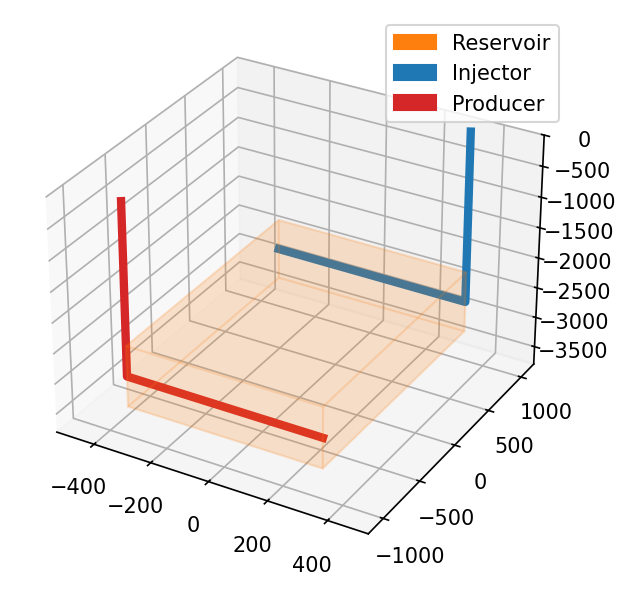

In [4]:
fig = project.reservoir.plot_doublet()

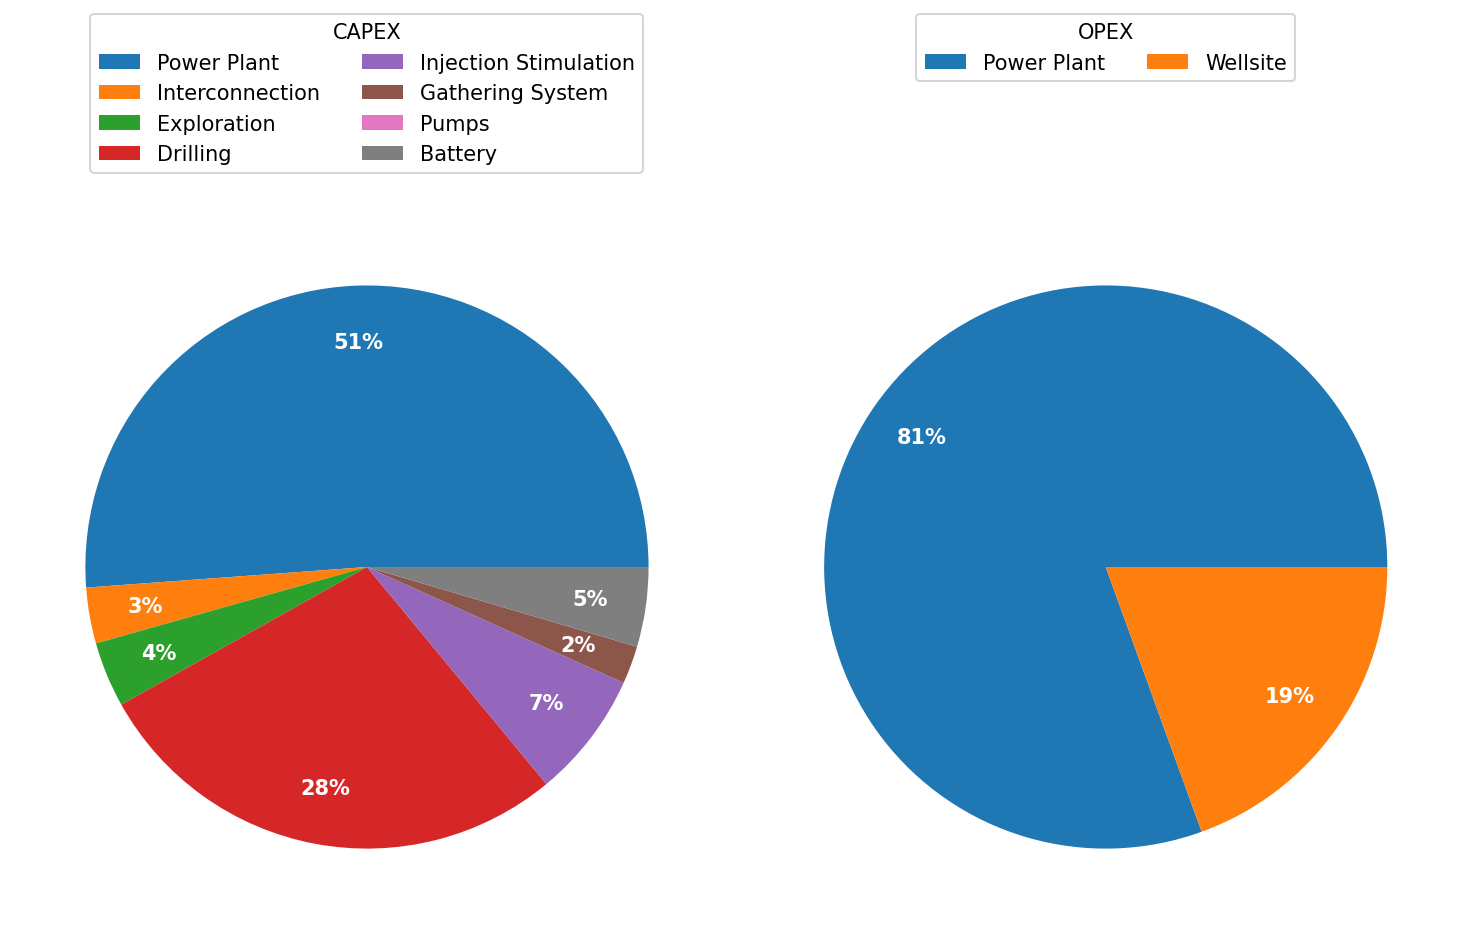

In [5]:
fig = project.plot_economics()

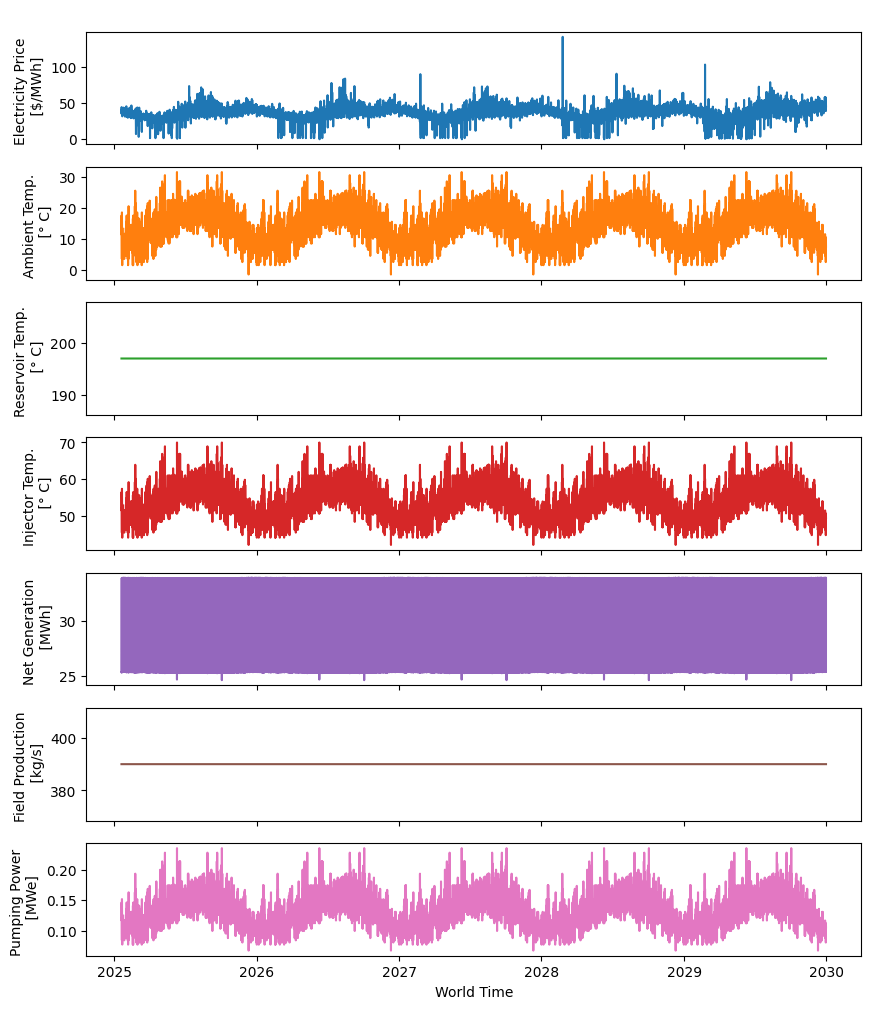

In [6]:
fig = project.plot_operations()

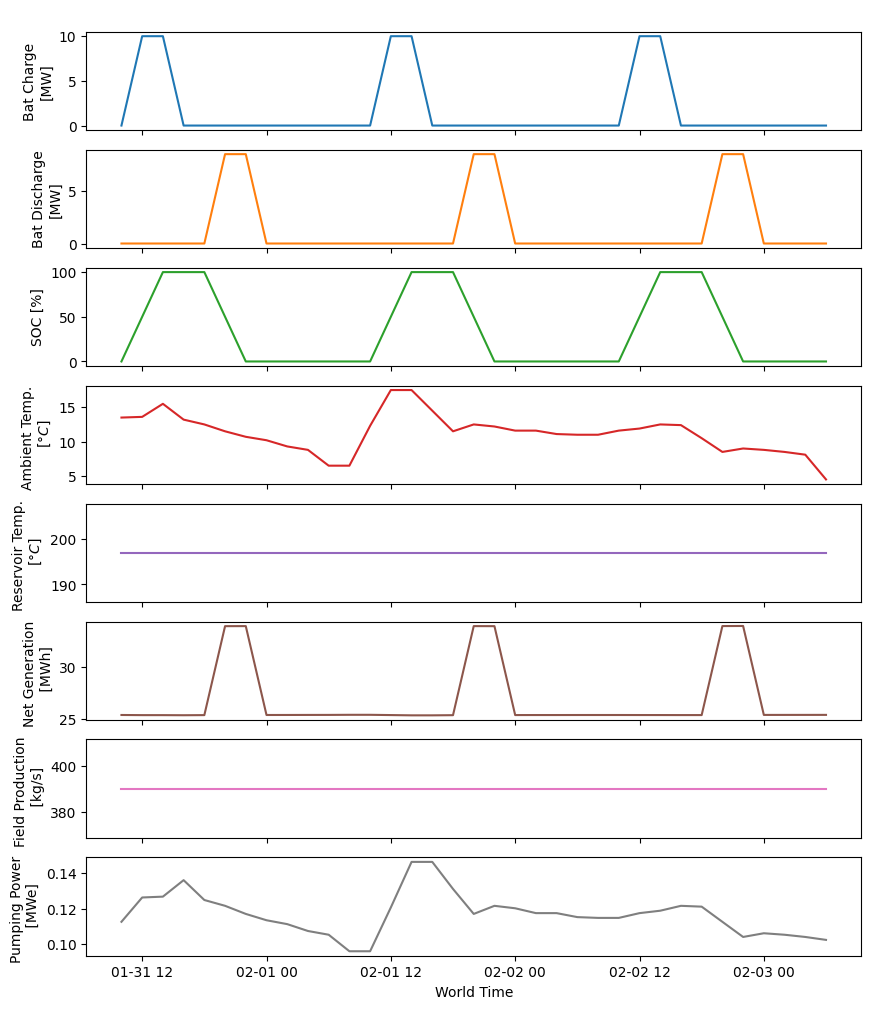

In [7]:
from fgem.utils import * 

qdict = {
          "Bat Charge From PP [MWe]": "Bat Charge\n[MW]",
          "Bat Discharge [MWe]": "Bat Discharge\n[MW]",
          "SOC [%]": "SOC [%]",
          "Atm Temp [deg C]": "Ambient Temp. \n [$\degree C$]",
          "Res Temp [deg C]": "Reservoir Temp. \n [$\degree C$]",
          "Net Power Output [MWe]": "Net Generation \n [MWh]",
          'M_Produced [kg/s]': "Field Production \n [kg/s]",
          "Pumping Power [MWe]": "Pumping Power \n [MWe]",
#           "WH Temp [deg C]": "Producer\nTemp. [$\degree C$]",
}

quantities = list(qdict.keys())
ylabels = list(qdict.values())

# span = range(365, project.max_simulation_steps-1)
span = range(365, 400)
fig = plot_cols({" ": project.df_records}, span, quantities, 
                         figsize=(10,12), ylabels=ylabels, legend_loc=False, dpi=100, 
                       formattime=False)